In [17]:
import pandas as pd
import requests
import time


# -------------------------------------------------------
# STEP 1 – Fetch countries master
# -------------------------------------------------------

url = "https://api.worldbank.org/countries?format=json&per_page=300"
response = requests.get(url)
data = response.json()

countries = pd.DataFrame(data[1])

countries["region"] = countries["region"].apply(lambda x: x["value"])
countries["incomeLevel"] = countries["incomeLevel"].apply(lambda x: x["value"])
countries["lendingType"] = countries["lendingType"].apply(lambda x: x["value"])

countries.drop(columns=["adminregion"], inplace=True, errors="ignore")
countries.rename(columns={"iso2Code": "country_id"}, inplace=True)


# -------------------------------------------------------
# STEP 2 – Common fetch function
# -------------------------------------------------------

BASE_URL = "https://api.worldbank.org/countries/all/indicators/{}?format=json&per_page=1000&page={}"


def fetch_indicator_group(indicators, min_year=2016):

    all_dfs = []

    for indicator_code in indicators:

        print(f"Fetching indicator: {indicator_code}")
        page = 1

        while True:

            url = BASE_URL.format(indicator_code, page)
            response = requests.get(url)

            if response.status_code != 200:
                print(f"Failed request for {indicator_code} page {page}")
                break

            data = response.json()

            if len(data) < 2:
                break

            total_pages = data[0]["pages"]
            records = data[1]

            df = pd.json_normalize(records)

            df = df[[
                "country.id",
                "country.value",
                "indicator.id",
                "indicator.value",
                "date",
                "value"
            ]].rename(columns={
                "country.id": "country_id",
                "country.value": "country_name",
                "indicator.id": "indicator_id",
                "indicator.value": "indicator_name",
                "date": "year"
            })

            df["year"] = df["year"].astype(int)
            df = df[df["year"] >= min_year]

            all_dfs.append(df)

            if page >= total_pages:
                break

            page += 1
            time.sleep(0.3)

    if all_dfs:
        return pd.concat(all_dfs, ignore_index=True)
    else:
        return pd.DataFrame()


# -------------------------------------------------------
# STEP 3 – Indicator groups
# -------------------------------------------------------

indicator_groups = {

    "economic": [
        "NY.GDP.MKTP.KD.ZG",
        "NY.GDP.PCAP.CD"
    ],

    "labour_market": [
        "SL.UEM.TOTL.ZS",
        "SL.UEM.1524.ZS",
        "SL.TLF.TOTL.IN"
    ],

    "trade": [
        "NE.EXP.GNFS.CD",
        "NE.IMP.GNFS.CD"
    ],

    "poverty": [
        "SI.POV.NAHC",
        "SI.POV.GINI"
    ],

    "environment": [
        "EG.FEC.RNEW.ZS",
        "AG.LND.FRST.ZS"
    ],

    "health": [
        "SP.DYN.LE00.IN",
        "SP.DYN.IMRT.IN",
        "SH.H2O.BASW.ZS",
        "SH.XPD.CHEX.GD.ZS",
        "SH.IMM.IDPT",
        "SH.IMM.MEAS",
        "SH.MMR.RISK.ZS",
        "SH.DTH.COMM.ZS",
        "SH.TBS.INCD",
        "SH.STA.BRTC.ZS",
        "SH.STA.MMRT",
        "SP.POP.65UP.TO.ZS",
        "SH.HIV.INCD.ZS"
    ],

    "technology": [
        "IT.NET.USER.ZS",
        "IT.CEL.SETS.P2"
    ]
}


# -------------------------------------------------------
# STEP 4 – Fetch, merge with countries and save CSVs
# -------------------------------------------------------

for category, indicators in indicator_groups.items():

    print(f"\n--- Fetching {category} indicators ---")

    df = fetch_indicator_group(indicators)

    if df.empty:
        print(f"No data for {category}")
        continue

    final_df = pd.merge(
        df,
        countries,
        on="country_id",
        how="inner"
    )

    final_df.drop(columns=["indicator_id", "name", "id"], inplace=True, errors="ignore")

    file_name = f"{category}.csv"
    final_df.to_csv(file_name, index=False)

    print(f"{file_name} saved with {len(final_df)} rows")


print("\nAll data fetching completed.")



--- Fetching economic indicators ---
Fetching indicator: NY.GDP.MKTP.KD.ZG
Fetching indicator: NY.GDP.PCAP.CD
economic.csv saved with 4788 rows

--- Fetching labour_market indicators ---
Fetching indicator: SL.UEM.TOTL.ZS
Fetching indicator: SL.UEM.1524.ZS
Fetching indicator: SL.TLF.TOTL.IN
labour_market.csv saved with 7182 rows

--- Fetching trade indicators ---
Fetching indicator: NE.EXP.GNFS.CD
Fetching indicator: NE.IMP.GNFS.CD
trade.csv saved with 4788 rows

--- Fetching poverty indicators ---
Fetching indicator: SI.POV.NAHC
Fetching indicator: SI.POV.GINI


C:\Users\khush\AppData\Local\Temp\ipykernel_16040\3445304242.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_dfs, ignore_index=True)


poverty.csv saved with 4788 rows

--- Fetching environment indicators ---
Fetching indicator: EG.FEC.RNEW.ZS
Fetching indicator: AG.LND.FRST.ZS
environment.csv saved with 4788 rows

--- Fetching health indicators ---
Fetching indicator: SP.DYN.LE00.IN
Fetching indicator: SP.DYN.IMRT.IN
Fetching indicator: SH.H2O.BASW.ZS
Fetching indicator: SH.XPD.CHEX.GD.ZS
Fetching indicator: SH.IMM.IDPT
Fetching indicator: SH.IMM.MEAS
Fetching indicator: SH.MMR.RISK.ZS
Fetching indicator: SH.DTH.COMM.ZS
Fetching indicator: SH.TBS.INCD
Fetching indicator: SH.STA.BRTC.ZS
Fetching indicator: SH.STA.MMRT
Fetching indicator: SP.POP.65UP.TO.ZS
Fetching indicator: SH.HIV.INCD.ZS
health.csv saved with 31122 rows

--- Fetching technology indicators ---
Fetching indicator: IT.NET.USER.ZS
Fetching indicator: IT.CEL.SETS.P2
technology.csv saved with 4788 rows

All data fetching completed.


In [37]:
environment = pd.read_csv("environment.csv")
technology = pd.read_csv("technology.csv")
health = pd.read_csv("health.csv")
trade = pd.read_csv("trade.csv")
labour_market = pd.read_csv("labour_market.csv")
poverty = pd.read_csv("poverty.csv")
economic = pd.read_csv("economic.csv")

In [36]:
economic

,country_id,country_name,indicator_name,year,value,region,incomeLevel,lendingType,capitalCity,longitude,latitude
0,ZH,Africa Eastern and Southern,GDP growth (annual %),2024,2.763839,Aggregates,Aggregates,Aggregates,NaN,NaN,NaN
1,ZH,Africa Eastern and Southern,GDP growth (annual %),2023,1.931160,Aggregates,Aggregates,Aggregates,NaN,NaN,NaN
2,ZH,Africa Eastern and Southern,GDP growth (annual %),2022,3.722717,Aggregates,Aggregates,Aggregates,NaN,NaN,NaN
3,ZH,Africa Eastern and Southern,GDP growth (annual %),2021,4.578772,Aggregates,Aggregates,Aggregates,NaN,NaN,NaN
4,ZH,Africa Eastern and Southern,GDP growth (annual %),2020,-2.817572,Aggregates,Aggregates,Aggregates,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4783,ZW,Zimbabwe,GDP per capita (current US$),2020,2059.674454,Sub-Saharan Africa,Lower middle income,Blend,Harare,31.0672,-17.8312
4784,ZW,Zimbabwe,GDP per capita (current US$),2019,2184.329239,Sub-Saharan Africa,Lower middle income,Blend,Harare,31.0672,-17.8312
4785,ZW,Zimbabwe,GDP per capita (current US$),2018,2270.895319,Sub-Saharan Africa,Lower middle income,Blend,Harare,31.0672,-17.8312
4786,ZW,Zimbabwe,GDP per capita (current US$),2017,3445.449410,Sub-Saharan Africa,Lower middle income,Blend,Harare,31.0672,-17.8312


In [2]:
import zipfile
import os

files = [
    "economic1.csv",
    "health.csv",
    "environment1.csv",
    "trade1.csv",
    "poverty1.csv",
    "labour_market.csv",
    "technology.csv"
]

with zipfile.ZipFile("worldbank_csv.zip", "w") as z:
    for f in files:
        if os.path.exists(f):
            z.write(f)

print("Zip created")

Zip created


In [3]:
health = pd.read_csv("health.csv")

In [4]:
df_wide = health.pivot_table(index=["country_name","year"],
                             columns="indicator_name",
                             values="value"
                             )

In [5]:
df_wide

indicator_name     Births attended by skilled health staff (% of total)  \
country_name year                                                         
Afghanistan  2016                                                NaN      
             2017                                               53.4      
             2018                                               58.8      
             2019                                                NaN      
             2020                                               61.8      
...                                                              ...      
Zimbabwe     2020                                                NaN      
             2021                                                NaN      
             2022                                                NaN      
             2023                                                NaN      
             2024                                                NaN      

indicator_name     Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)  \
country_name year                                                                                                          
Afghanistan  2016                                                NaN                                                       
             2017                                                NaN                                                       
             2018                                                NaN                                                       
             2019                                          32.930451                                                       
             2020                                                NaN                                                       
...                                                              ...                                                       
Zimbabwe     2020                                                NaN                                                       
             2021                                                NaN                                                       
             2022                                                NaN                                                       
             2023                                                NaN                                                       
             2024                                                NaN                                                       

indicator_name     Current health expenditure (% of GDP)  \
country_name year                                          
Afghanistan  2016                              11.818590   
             2017                              12.620817   
             2018                              14.208419   
             2019                              14.831320   
             2020                              15.533614   
...                                                  ...   
Zimbabwe     2020                               2.954401   
             2021                               2.671119   
             2022                               3.395195   
             2023                               2.926016   
             2024                                    NaN   

indicator_name     Immunization, DPT (% of children ages 12-23 months)  \
country_name year                                                        
Afghanistan  2016                                               66.0     
             2017                                               64.0     
             2018                                               68.0     
             2019                                               65.0     
             2020                                               61.0     
...                                                              ...     
Zimbabwe     2020                     

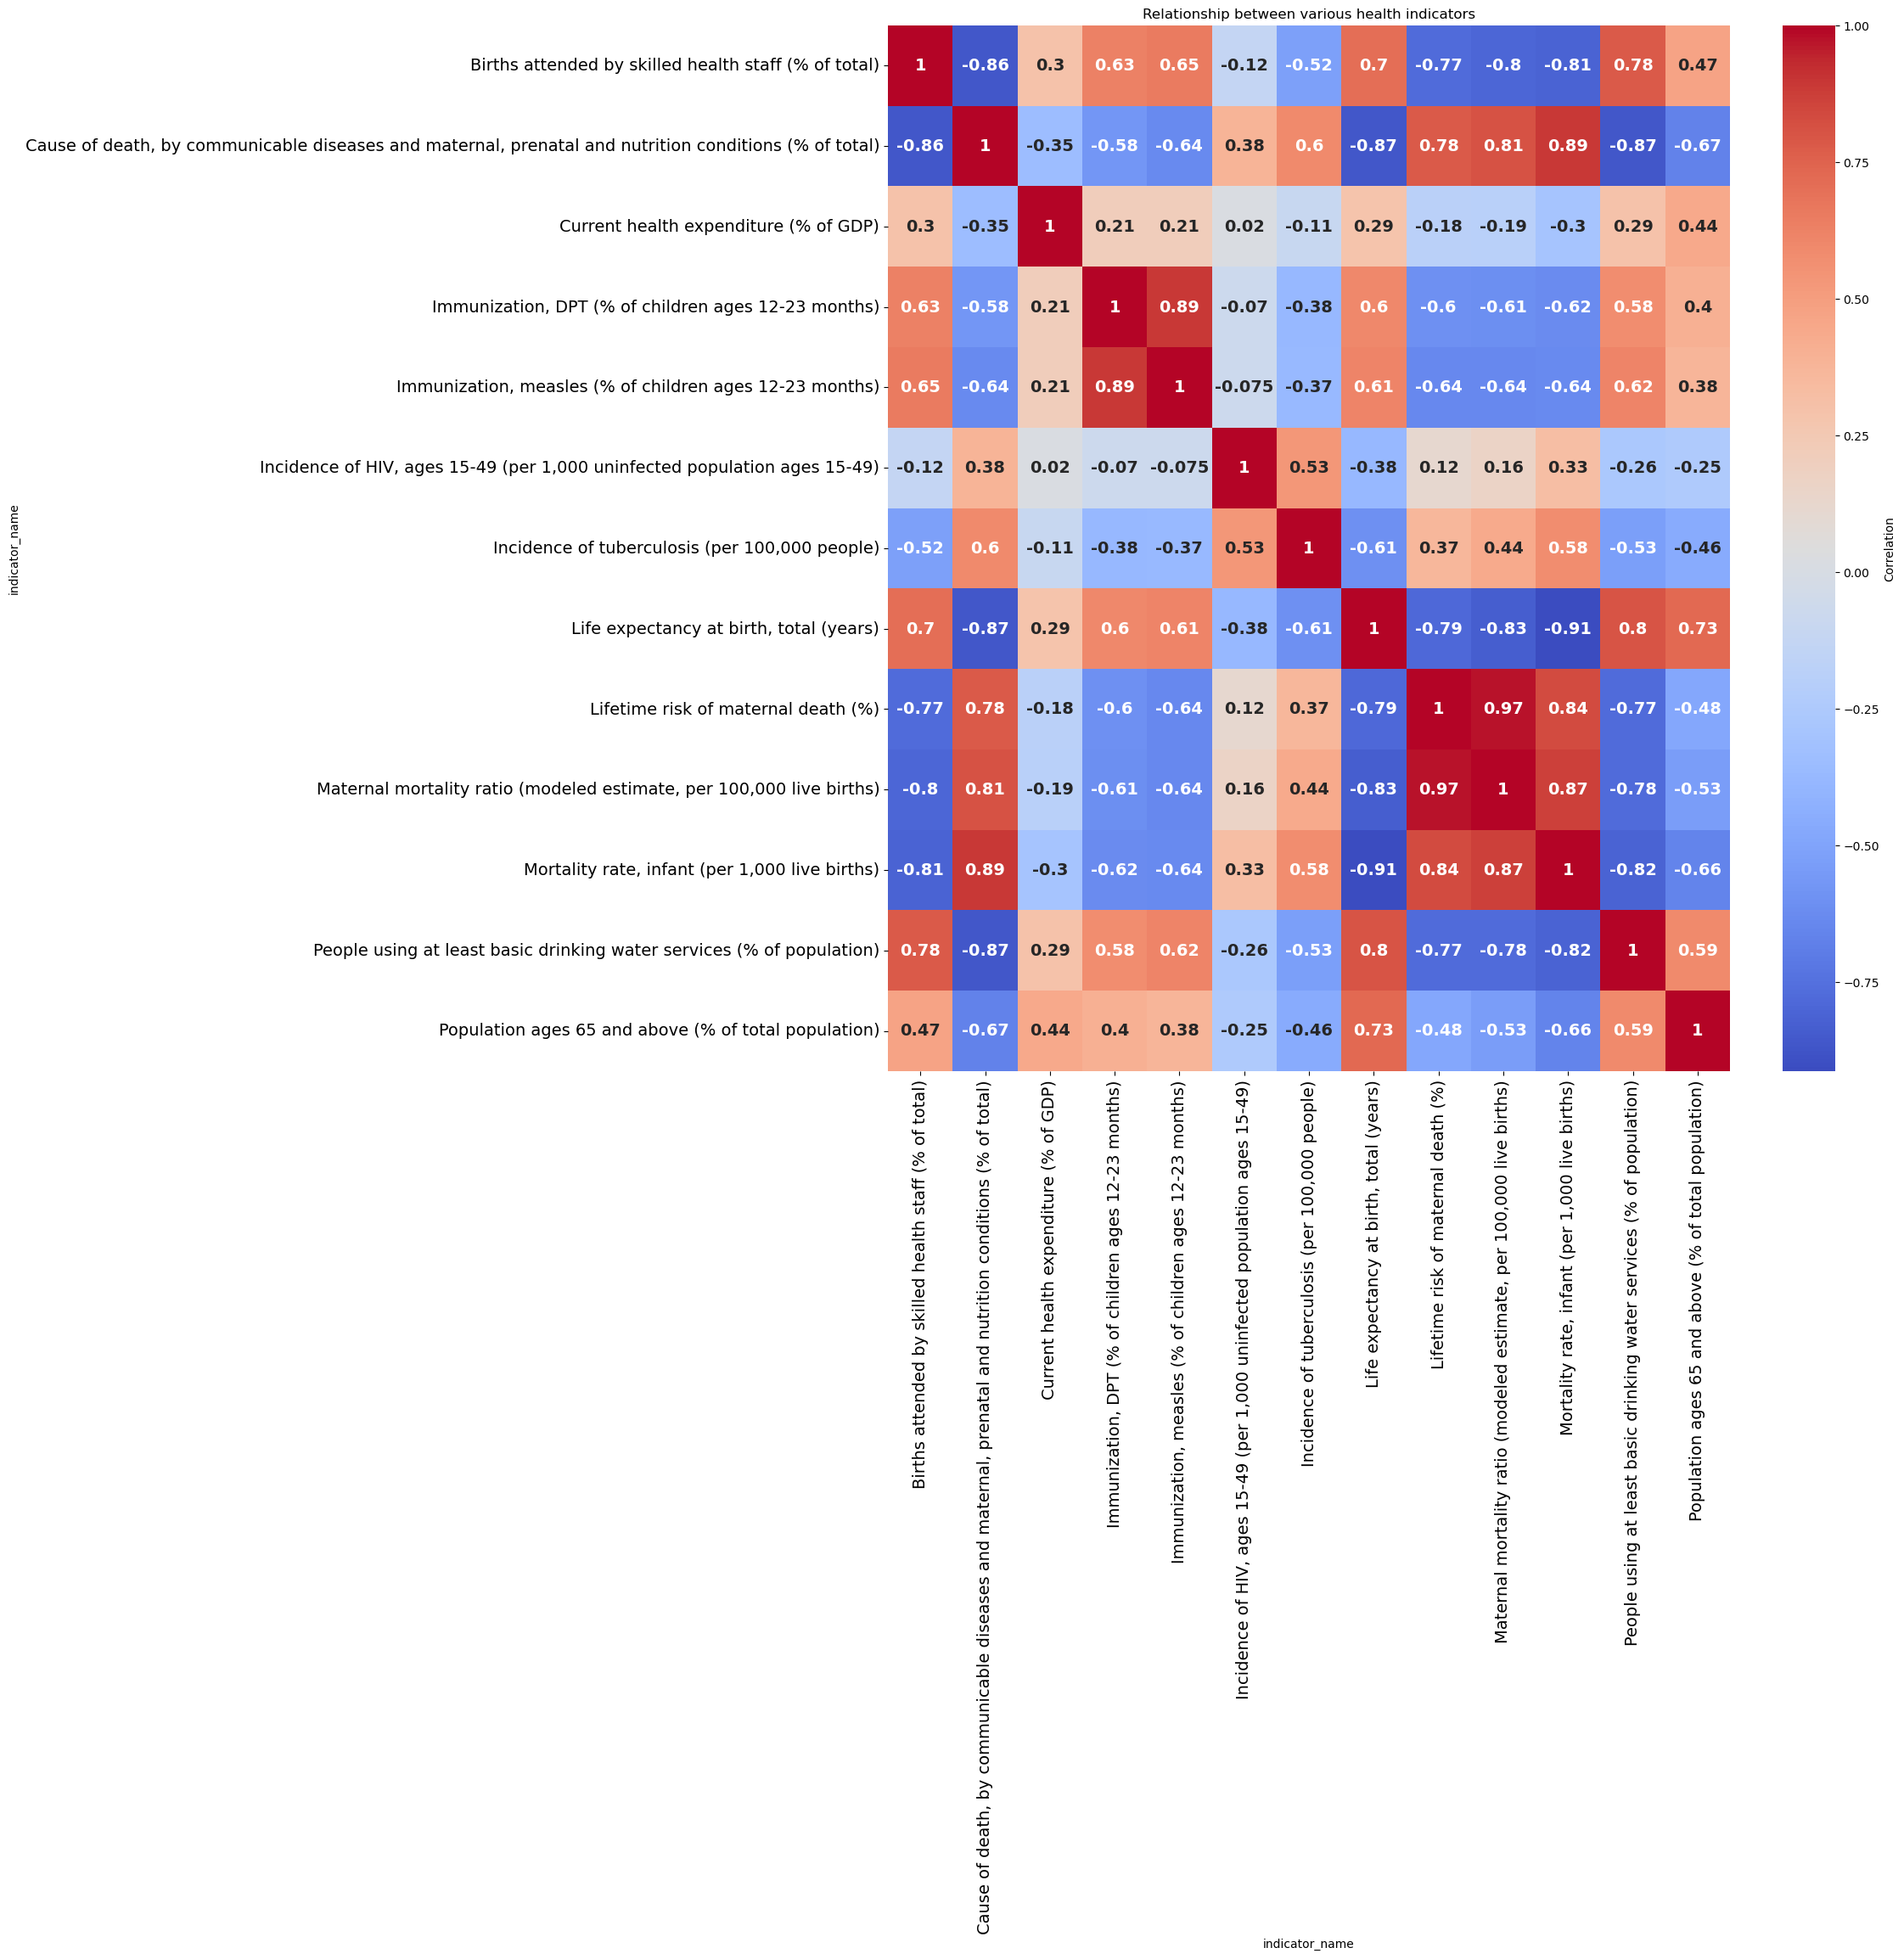

In [6]:
df_wide = health.pivot_table(index=["country_name","year"],
                             columns="indicator_name",
                             values="value"
                             )
corr= df_wide.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16), facecolor="none")
ax= sns.heatmap(
    corr,
    annot=True,
    cmap= "coolwarm",
    cbar_kws= {"label":"Correlation"},
    annot_kws= {"fontsize":14, "fontweight":"bold"}
)
plt.title("Relationship between various health indicators")

ax.tick_params(axis="x",labelsize=14)
ax.tick_params(axis="y",labelsize=14)
plt.show()

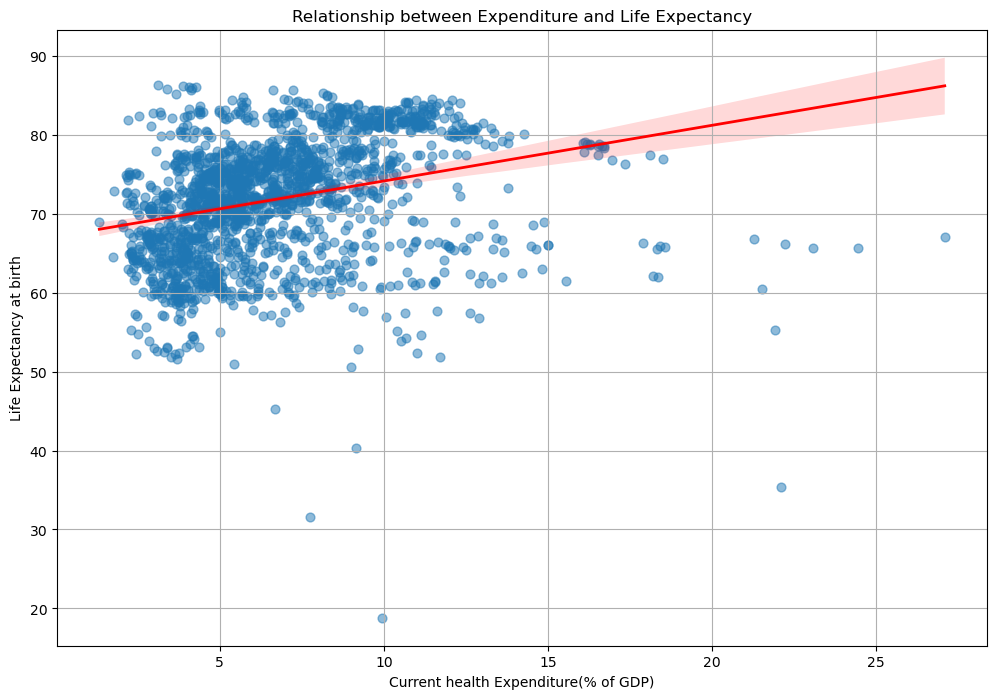

In [8]:
df_pivot= health.pivot(index=["country_name", "year"], columns="indicator_name", values="value").reset_index()

plt.figure(figsize=(12,8), facecolor="none")

ax=sns.regplot(data=df_pivot,
               x="Current health expenditure (% of GDP)",
               y="Life expectancy at birth, total (years)",
               scatter_kws= {"alpha":0.5, "s":40},
               line_kws={"color":"red","lw":2}
               )

plt.title("Relationship between Expenditure and Life Expectancy")
plt.xlabel("Current health Expenditure(% of GDP)")
plt.ylabel("Life Expectancy at birth")
plt.grid(True)
plt.show()